# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [69]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso, RidgeClassifierCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import make_pipeline

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

There are 10 different offers in the database, "Buy one get one free", discount, and informational which doesn't have any monetary value.

There are 4 different channels where the offers are promoted.

The difficulty (amount to spend) ranges from 0 to 20 dollars, while the reward is between 0 and 10.

The shortest offer duration is 3 days, the longest is 10.

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [70]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)
temp_channel = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio  = pd.concat([portfolio,temp_channel],axis=1)
temp_offer = pd.get_dummies(portfolio.offer_type).sum(level=0)
portfolio  = pd.concat([portfolio,temp_offer],axis=1)

The data about the customers have very little information, only age, gender, income, and the date of registration.

2175 customer have 118 as age, probably it is a default value and the other variables are also missing for these. Given that these rows don't have any information valuable for clustering, I will drop these customers.

In [71]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile[profile.age ==118]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [72]:
profile = profile[profile.age != 118]
profile['age_group'] = pd.cut(profile.age, bins=[17, 25, 40, 60, 118], labels=['18-25','26-40', '41-60', '60+'])
profile['became_member_on']=pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
# I assume the dataset is from eoy 2018
profile['membership_days'] = (pd.Timestamp('20190101')-profile['became_member_on']).dt.days

Text(0.5,1,'Age distribution')

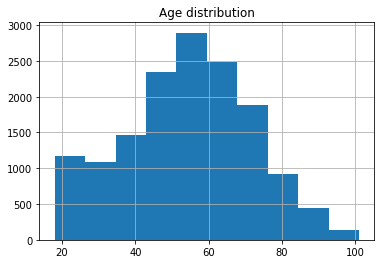

In [296]:
profile.age.hist()
plt.title('Age distribution')

Text(0.5,1,'Age-group distribution')

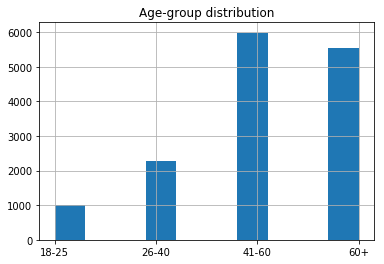

In [297]:
profile.age_group.hist()
plt.title('Age-group distribution')

In [23]:
profile[profile.age > 90]

,age,became_member_on,gender,id,income
33,96,20171117,F,868317b9be554cb18e50bc68484749a2,89000.0
283,100,20150828,F,24c1287eb7a84cfd80472a82e05b1d57,63000.0
530,94,20141128,M,00bbce6533f44ddeaf4dd32bcab55441,50000.0
634,95,20170913,F,5638a1d0d55a4556a64a87118fdfe695,64000.0
686,93,20131025,F,c1e4888e931740838f7ef3bbd04a114c,48000.0
751,94,20161130,F,56163abfe5a848debe17c970e7f0c2d1,84000.0
933,91,20170815,F,fb4d977017f24913a9602692fc881b2e,37000.0
949,92,20180601,M,c8c44530553d43e4aae1edf97153cf38,113000.0
977,96,20171128,F,f5112242df984403bfb4176d4487aef3,72000.0
1083,98,20180410,M,9696528cb958441180207375f8e608d5,52000.0


Quite a lot of customers are older than 90 years, for the moment I will keep it, but I take a mental note.

Text(0.5,1,'Income distribution')

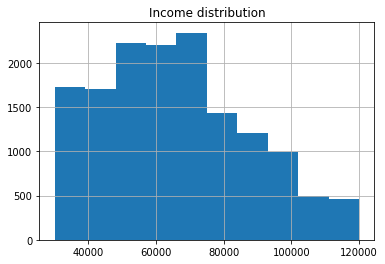

In [298]:
profile.income.hist()
plt.title('Income distribution')

Text(0.5,1,'Membership start distribution')

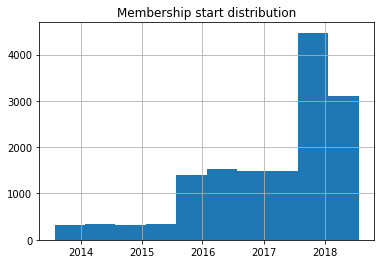

In [299]:
profile['became_member_on'].hist()
plt.title('Membership start distribution')

A huge increase in registrations in the second half of 2017

Text(0.5,1,'Gender distribution')

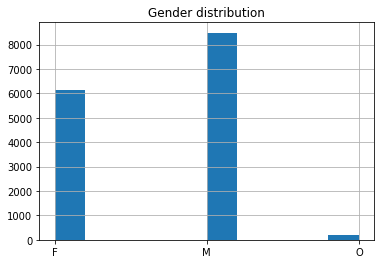

In [300]:
profile.gender.hist()
plt.title('Gender distribution')

In [10]:
transcript.head(25)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [15]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [18]:
transcript[transcript.person == '389bc3fa690240e798340f5a15918d5c']

,event,person,time,value
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
32625,transaction,389bc3fa690240e798340f5a15918d5c,60,{'amount': 9.54}
32626,offer completed,389bc3fa690240e798340f5a15918d5c,60,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
53179,offer received,389bc3fa690240e798340f5a15918d5c,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
77212,offer viewed,389bc3fa690240e798340f5a15918d5c,192,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
110831,offer received,389bc3fa690240e798340f5a15918d5c,336,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
132803,offer viewed,389bc3fa690240e798340f5a15918d5c,354,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
150601,offer received,389bc3fa690240e798340f5a15918d5c,408,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
179953,offer viewed,389bc3fa690240e798340f5a15918d5c,438,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


A really good blog post describes the difficulties of getting the valid offers from the transcript table. I used the methods applied there to create a valid_completed column.
https://towardsdatascience.com/using-starbucks-app-user-data-to-predict-effective-offers-20b799f3a6d5

In [73]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [74]:
#create new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [75]:
#join transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [161]:
transcript[transcript.event == 'transaction'].head(25)

,event,person,time,value,amount,email,mobile,social,web,bogo,discount,informational,offer_id,channels,difficulty,offer_type,reward,duration,offer_id_previous,valid_completed
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1.0
10,transaction,0009655768c64bdeb2e877511632db8f,528,{'amount': 14.11},14.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
13,transaction,0009655768c64bdeb2e877511632db8f,552,{'amount': 13.56},13.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
15,transaction,0009655768c64bdeb2e877511632db8f,576,{'amount': 10.27},10.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
17,transaction,0009655768c64bdeb2e877511632db8f,660,{'amount': 12.36},12.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
18,transaction,0009655768c64bdeb2e877511632db8f,690,{'amount': 28.16},28.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
19,transaction,0009655768c64bdeb2e877511632db8f,696,{'amount': 18.41},18.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
22,transaction,00116118485d4dfda04fdbaba9a87b5c,294,{'amount': 0.7000000000000001},0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
23,transaction,00116118485d4dfda04fdbaba9a87b5c,456,{'amount': 0.2},0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0


In [76]:
transcript.drop(['reward_x','reward_y'],axis = 1, inplace = True)

In [77]:
transcript=transcript.sort_values(['person','time'])

In [78]:
offers_view_transacted=transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

In [79]:
transcript=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [80]:
transcript=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])
transcript.drop(columns = ['offer_id_x','offer_id_y'],inplace = True)

In [81]:
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript['duration']=np.where(transcript['duration_x'].isnull(),transcript['duration_y'],transcript['duration_x'])
transcript.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [82]:
transcript.drop(columns = ['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],inplace = True)

In [31]:
transcript.columns

Index(['event', 'person', 'time', 'value', 'amount', 'email_x', 'mobile_x',
       'social_x', 'web_x', 'bogo_x', 'discount_x', 'informational_x',
       'offer_id', 'channels', 'difficulty', 'offer_type', 'reward', 'email_y',
       'mobile_y', 'social_y', 'web_y', 'bogo_y', 'discount_y',
       'informational_y', 'duration'],
      dtype='object')

In [83]:
offers_viewed_transactions_completed=transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)
offers_received=transcript[transcript['event']=='offer received'].copy()

offers_received['offer_id_previous']=np.nan
offers_received['valid_completed']=np.nan

transcript=offers_received.append(offers_viewed_transactions_completed)

transcript=transcript.sort_values(['person','time'])




In [160]:
transcript.columns

Index(['event', 'person', 'time', 'value', 'amount', 'email_x', 'mobile_x',
       'social_x', 'web_x', 'bogo_x', 'discount_x', 'informational_x',
       'offer_id', 'channels', 'difficulty', 'offer_type', 'reward', 'email_y',
       'mobile_y', 'social_y', 'web_y', 'bogo_y', 'discount_y',
       'informational_y', 'duration', 'offer_id_previous', 'valid_completed'],
      dtype='object')

In [84]:
transcript.rename(columns ={'email_x':'email', 'mobile_x':'mobile',
       'social_x':'social', 'web_x':'web', 'bogo_x':'bogo', 'discount_x':'discount', 'informational_x':'informational'},inplace= True)


In [85]:
transcript.drop(['email_y', 'mobile_y',
       'social_y', 'web_y', 'bogo_y', 'discount_y', 'informational_y'],axis=1,inplace=True)

In [86]:
transcript['valid_completed'] = transcript['valid_completed'].fillna(0)

In [164]:
transcript.columns

Index(['event', 'person', 'time', 'value', 'amount', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational', 'offer_id',
       'channels', 'difficulty', 'offer_type', 'reward', 'duration',
       'offer_id_previous', 'valid_completed'],
      dtype='object')

In [ ]:
completed = transcript[(transcript['valid_completed']==1) & (transcript['event']=='offer completed')][['person','offer_id','valid_completed']]


In [48]:
completed.drop_duplicates(inplace=True)

In [87]:
testest = transcript.groupby(['person','offer_id'])['valid_completed'].max().reset_index()

In [88]:
testest.drop_duplicates(inplace=True)

In [89]:
testdf2 = transcript[transcript['event']=='offer received'].merge(testest, how = 'left', on = ['person','offer_id'])

In [90]:
testdf2.columns

Index(['event', 'person', 'time', 'value', 'amount', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational', 'offer_id',
       'channels', 'difficulty', 'offer_type', 'reward', 'duration',
       'offer_id_previous', 'valid_completed_x', 'valid_completed_y'],
      dtype='object')

In [91]:
df = testdf2[['person', 'time', 'amount', 'email', 'mobile',
       'social', 'web', 'discount', 'informational', 'offer_id',
       'difficulty', 'reward', 'duration', 'valid_completed_y']]

In [92]:
profile.rename(columns={'id':'person'}, inplace=True)

In [93]:
df=df.merge(profile, how='left', on ='person')

In [94]:
income_cuts = [0, 48000, 62000, 78000, 95000, 120001]
df = pd.concat([df, pd.get_dummies(pd.cut(df['income'], income_cuts, labels=['48k', '62k','78k','95k','+95k']))], axis=1)
gender_dummies = pd.get_dummies(df['gender'], prefix = 'gender')
df = pd.concat([df, gender_dummies], axis=1)
age_group_dummies = pd.get_dummies(df['age_group'], prefix= 'age_group')
df = pd.concat([df, age_group_dummies], axis=1)

In [95]:
year_labels = [2013,2014,2015,2016,2017,2018]
year_cuts = [2013,2014,2015,2016,2017,2018,2019]
year_dummies = pd.get_dummies(pd.cut(df.became_member_on.dt.year, year_cuts, labels=year_labels))
df = pd.concat([df, year_dummies], axis=1)

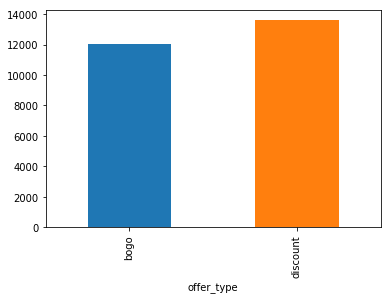

In [40]:
transcript[(transcript['valid_completed']==1) & (transcript['event']=='offer completed')].groupby(['offer_type'])['valid_completed'].count().plot(kind="bar");

In [52]:
transcript[(transcript.person=='0009655768c64bdeb2e877511632db8f') & (transcript.offer_id =='5a8bc65990b245e5a138643cd4eb9837')]

,event,person,time,value,amount,email,mobile,social,web,bogo,discount,informational,offer_id,channels,difficulty,offer_type,reward,duration,offer_id_previous,valid_completed
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0


In [62]:
testdf2

,event,person,time,value,amount,email,mobile,social,web,bogo,...,informational,offer_id,channels,difficulty,offer_type,reward,duration,offer_id_previous,valid_completed_x,valid_completed_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,1.0,1.0,1.0,0.0,0.0,...,1.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0,1.0
1,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,1.0,1.0,0.0,1.0,0.0,...,1.0,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0,1.0
2,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,1.0,1.0,1.0,1.0,1.0,...,0.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,1.0,1.0,1.0,1.0,0.0,...,0.0,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,0.0,1.0
4,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,1.0,1.0,0.0,1.0,0.0,...,0.0,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,discount,2,7.0,NaN,0.0,0.0
5,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,1.0,1.0,1.0,1.0,1.0,...,0.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0,1.0
6,offer received,00116118485d4dfda04fdbaba9a87b5c,576,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,1.0,1.0,1.0,1.0,1.0,...,0.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0,1.0
7,offer received,0011e0d4e6b944f998e987f904e8c1e5,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,1.0,1.0,0.0,1.0,0.0,...,1.0,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0,1.0
8,offer received,0011e0d4e6b944f998e987f904e8c1e5,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN,1.0,1.0,1.0,1.0,0.0,...,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,discount,3,7.0,NaN,0.0,1.0
9,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,1.0,1.0,1.0,0.0,0.0,...,1.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0,0.0


In [43]:
transcript[(transcript['valid_completed']==0) & (transcript['event']=='offer received')]

,event,person,time,value,amount,email,mobile,social,web,bogo,discount,informational,offer_id,channels,difficulty,offer_type,reward,duration,offer_id_previous,valid_completed
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,1.0,1.0,1.0,1.0,0.0,1.0,0.0,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,discount,2,10.0,NaN,0.0
14,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,discount,2,7.0,NaN,0.0
20,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0
25,offer received,00116118485d4dfda04fdbaba9a87b5c,576,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,bogo,5,5.0,NaN,0.0
27,offer received,0011e0d4e6b944f998e987f904e8c1e5,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,1.0,1.0,0.0,1.0,0.0,0.0,1.0,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0,NaN,0.0
30,offer received,0011e0d4e6b944f998e987f904e8c1e5,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2298d6c36e964ae4a3e7e9706d1fb8c2,"[web, email, mobile, social]",7,discount,3,7.0,NaN,0.0
34,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,1.0,1.0,1.0,0.0,0.0,0.0,1.0,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0,NaN,0.0


In [38]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

Text(0.5,1,'Completed offers by type')

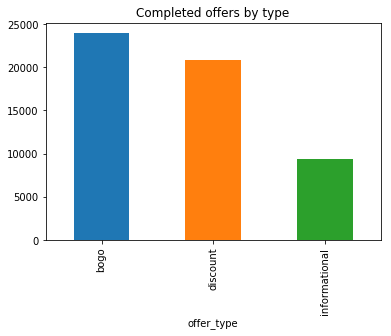

In [302]:
testdf2[testdf2.valid_completed_y==1].groupby(['offer_type'])['offer_type'].count().plot(kind="bar");
plt.title('Completed offers by type')

I will investigate a bit more the more popular offers, response rate etc using descriptive statistics.

In [237]:
portfolio

,channels,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


In [303]:
df.columns

Index([           'person',              'time',            'amount',
                   'email',            'mobile',            'social',
                     'web',          'discount',     'informational',
                'offer_id',        'difficulty',            'reward',
                'duration', 'valid_completed_y',               'age',
        'became_member_on',            'gender',            'income',
               'age_group',   'membership_days',               '48k',
                     '62k',               '78k',               '95k',
                    '+95k',          'gender_F',          'gender_M',
                'gender_O',   'age_group_18-25',   'age_group_26-40',
         'age_group_41-60',     'age_group_60+',                2013,
                      2014,                2015,                2016,
                      2017,                2018],
      dtype='object')

Text(0.5,1,'Total amount spent by offer type')

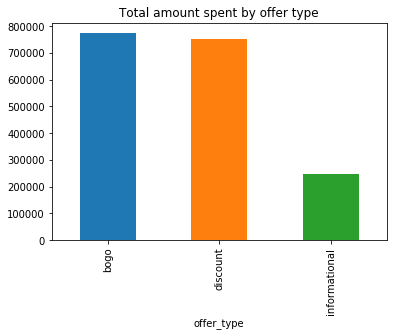

In [307]:
transcript.groupby('offer_type')['amount'].sum().plot(kind='bar')
plt.title('Total amount spent by offer type')

In [240]:
X = df[[ 'amount', 'email', 'mobile', 'social', 'web',
       'discount', 'informational', 'difficulty', 'reward',
       'duration',
        '48k', '62k', '78k', '95k', '+95k', 'gender_F',
       'gender_M', 'gender_O','age_group_18-25', 'age_group_26-40',
       'age_group_41-60', 'age_group_60+','membership_days']]
       
       #,2013,
       #              2014,               2015,               2016,
       #              2017,               2018]]

In [241]:
X=X.fillna(0)

In [242]:
y = df.valid_completed_y.astype(float)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [244]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.60      0.41      0.49      6647
        1.0       0.79      0.89      0.83     16237

avg / total       0.73      0.75      0.73     22884



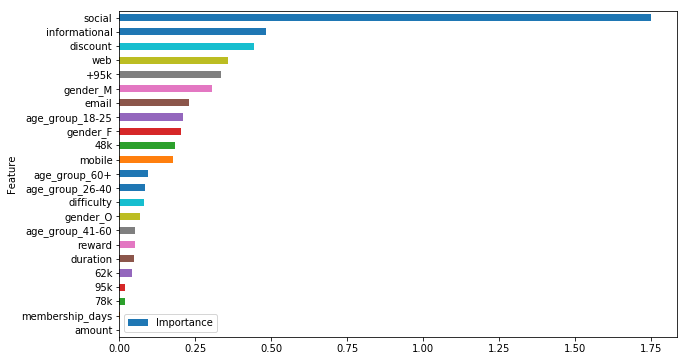

In [245]:
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

I will experiment with different classifiers etc.

In [114]:
X.columns

Index([         'amount',           'email',          'mobile',
                'social',             'web',        'discount',
         'informational',      'difficulty',          'reward',
              'duration',             '48k',             '62k',
                   '78k',             '95k',            '+95k',
              'gender_F',        'gender_M',        'gender_O',
       'age_group_18-25', 'age_group_26-40', 'age_group_41-60',
         'age_group_60+', 'membership_days',              2013,
                    2014,              2015,              2016,
                    2017,              2018],
      dtype='object')

In [246]:
X2 = X[['48k',             '62k',
                   '78k',             '95k',            '+95k',
              'gender_F',        'gender_M',        'gender_O',
       'age_group_18-25', 'age_group_26-40', 'age_group_41-60',
         'age_group_60+', 'membership_days']]
#,              2013,
#                    2014,              2015,              2016,
#                    2017,              2018]]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3, random_state=42)

In [281]:
#Logistic regression
model = Pipeline([('scl', StandardScaler()), ('clf',LogisticRegression())])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

        0.0       0.60      0.41      0.49      6647
        1.0       0.79      0.89      0.83     16237

avg / total       0.73      0.75      0.73     22884



Text(0.5,1,'Logistic Regression Classifier')

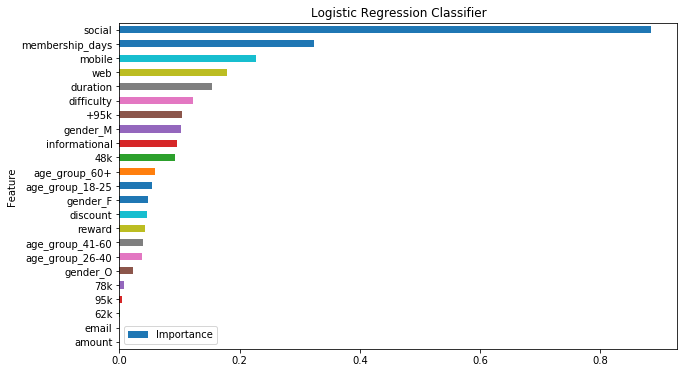

In [282]:
coefficients = model.named_steps['clf'].coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Logistic Regression Classifier')

In [276]:
#XGBoost
model = Pipeline([('scl', StandardScaler()), ('clf',GradientBoostingClassifier())])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

        0.0       0.62      0.42      0.50      6647
        1.0       0.79      0.89      0.84     16237

avg / total       0.74      0.76      0.74     22884



In [274]:
#Using decision trees
from sklearn.pipeline import Pipeline

model = Pipeline([('scl', StandardScaler()), ('clf',DecisionTreeClassifier())])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.54      0.49      0.51      6647
        1.0       0.80      0.83      0.81     16237

avg / total       0.72      0.73      0.73     22884



Text(0.5,1,'Decision Tree Classifier')

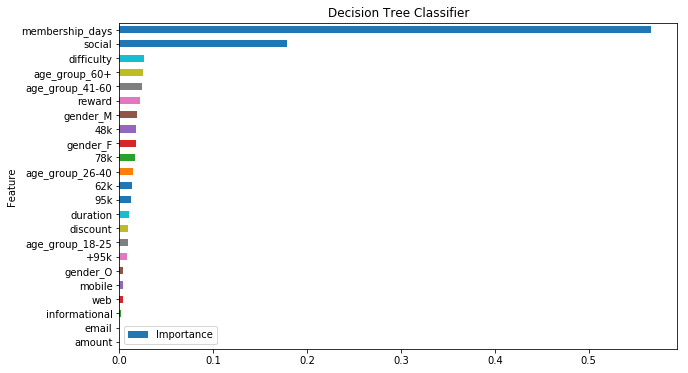

In [275]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.named_steps['clf'].tree_.compute_feature_importances(normalize=True)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Decision Tree Classifier')

In [269]:
#Using decision trees

model = Pipeline([('scl', StandardScaler()), ('clf',RidgeClassifier())])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.60      0.39      0.47      6647
        1.0       0.78      0.89      0.83     16237

avg / total       0.73      0.75      0.73     22884



Text(0.5,1,'Ridge Classifier')

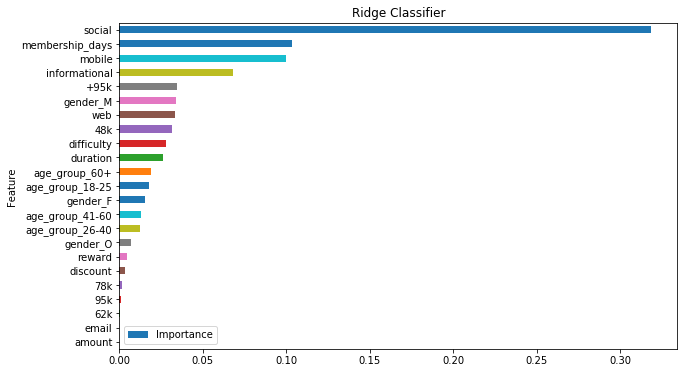

In [271]:
coefficients = model.named_steps['clf'].coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Ridge Classifier')

In [283]:
#Logistic regression
model = Pipeline([('scl', StandardScaler()), ('clf',LogisticRegression())])

model.fit(X2_train, y2_train)
y2_pred = model.predict(X2_test)

print(classification_report(y2_test, y2_pred))


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      6647
        1.0       0.71      1.00      0.83     16237

avg / total       0.50      0.71      0.59     22884



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0.5,1,'Logistic Regression Classifier')

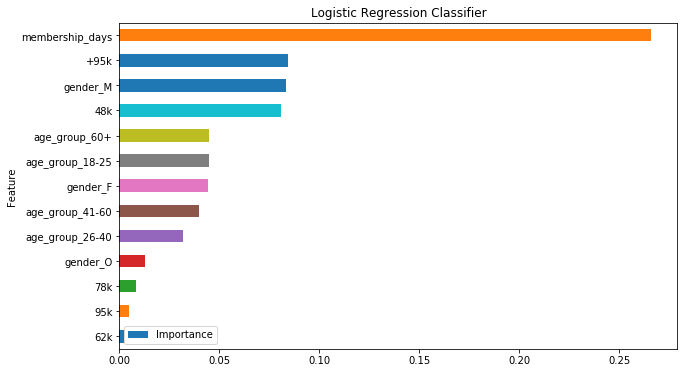

In [288]:
coefficients = model.named_steps['clf'].coef_[0]
feature_importance = pd.DataFrame({'Feature': X2.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Logistic Regression Classifier')

In [289]:
#XGBoost
model = Pipeline([('scl', StandardScaler()), ('clf',GradientBoostingClassifier())])

model.fit(X2_train, y2_train)
y2_pred = model.predict(X2_test)

print(classification_report(y2_test, y2_pred))


             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      6647
        1.0       0.71      1.00      0.83     16237

avg / total       0.50      0.71      0.59     22884



In [290]:
#Using decision trees
model = Pipeline([('scl', StandardScaler()), ('clf',DecisionTreeClassifier())])
model.fit(X2_train, y2_train)
y_pred = model.predict(X2_test)

print(classification_report(y2_test, y2_pred))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      6647
        1.0       0.71      1.00      0.83     16237

avg / total       0.50      0.71      0.59     22884



Text(0.5,1,'Decision Tree Classifier')

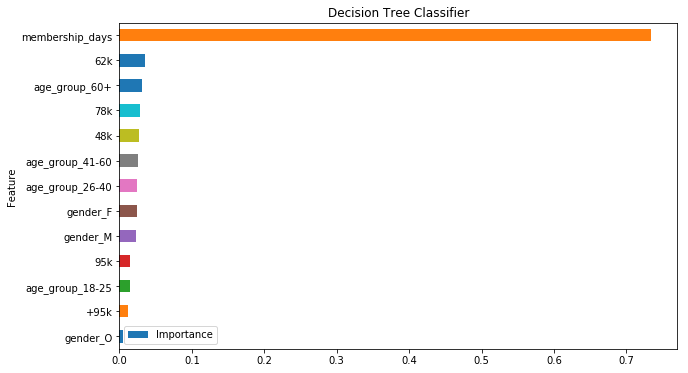

In [291]:
feature_importance = pd.DataFrame({'Feature': X2.columns, 'Importance': model.named_steps['clf'].tree_.compute_feature_importances(normalize=True)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Decision Tree Classifier')

In [292]:
#Using ridge
model = Pipeline([('scl', StandardScaler()), ('clf',RidgeClassifier())])
model.fit(X2_train, y2_train)
y_pred = model.predict(X2_test)

print(classification_report(y2_test, y2_pred))

             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00      6647
        1.0       0.71      1.00      0.83     16237

avg / total       0.50      0.71      0.59     22884



Text(0.5,1,'Ridge Classifier')

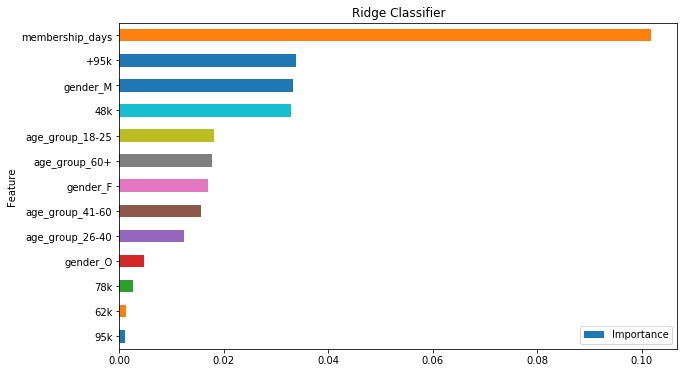

In [293]:
coefficients = model.named_steps['clf'].coef_[0]

feature_importance = pd.DataFrame({'Feature': X2.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title('Ridge Classifier')